In [48]:
# Code adapted from Shashaank Vattikuti's notebook code 

# Imports

In [29]:
from matplotlib.pyplot import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numpy import *
import pandas as pd
import niddk_covid_sicr as ncs
from datetime import datetime, timedelta
from pathlib import Path
import seaborn as sns

In [30]:
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

# Paths

In [49]:
data_path = './data'
casepath = data_path + '/covidtimeseries_'
fits_path = '/data/schwartzao/covid-sicr/fits/test'
models_path = './models/'
tables_path = './tables/test'
figures_path = './figures/test'

# Get data

In [38]:
! python scripts/get-data.py

Getting data from jhu...
Could not download data for recovered, US
US States:   0%|                                         | 0/58 [00:00<?, ?it/s]Skipping Diamond Princess
Skipping Grand Princess
Skipping US_AS
US States: 100%|████████████████████████████████| 58/58 [00:01<00:00, 39.56it/s]
Getting data from canada...
Canadian Provinces: 100%|███████████████████████| 13/13 [00:00<00:00, 38.56it/s]
Getting data from brazil...
Brazilian States: 100%|█████████████████████████| 27/27 [00:00<00:00, 50.21it/s]
Replacing missing columns with -1 in daily data...
Regions:  83%|█████████████████████████▊     | 233/280 [00:01<00:00, 137.46it/s]Negifying 'new_deaths' for NWT
Negifying 'new_deaths' for PEI
Negifying 'new_recover' for Sweden
Regions: 100%|███████████████████████████████| 280/280 [00:02<00:00, 139.24it/s]
Removing old regions that no longer report data:
Data now available at /spin1/home/linux/schwartzao/covid-sicr/data


# Run model

In [39]:
roi = 'US_NY'
model = 'Discrete1'

In [40]:
! python scripts/run.py {model} -r={roi} -mp={models_path} -fp={fits_path} -it=100 -wm=20 -ch=8 -ft=1 -tw=1

Could not use mitigation prior data; setting mitigation prior to default.
Using default values to initialize fit


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 3
           adapt_window = 15
           term_buffer = 2


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 3
           adapt_window = 15
           term_buffer = 2

Iteration:  1 / 100 [  1%]  (Warmup)

Iteration:  1 / 100 [  1%]  (Warmup)



# Visualize fit

### Define functions for weekly data

In [42]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

def plotXt(ax,Xt,x,c):
    Xtlb = percentile(Xt,2.5,axis=0)
    Xtm = percentile(Xt,50,axis=0)
    Xtub = percentile(Xt,97.5,axis=0)
    
    ax.plot(x,Xtm,color=c,lw=lw,label="median")
    ax.fill_between(x,Xtlb,Xtub,color=c,alpha=a)
    ax.plot(x,Xtlb,color='k')
    ax.plot(x,Xtub,color='k')
    simpleaxis(ax)

    return

###### AOS ADDED #########
def plot_ts_weekly(ax,c,r,d,x,df):
    Clb = percentile(c,2.5,axis=0)
    Cm = percentile(c,50,axis=0)
    Cub = percentile(c,97.5,axis=0)

    Rlb = percentile(r,2.5,axis=0)
    Rm = percentile(r,50,axis=0)
    Rub = percentile(r,97.5,axis=0)

    Dlb = percentile(d,2.5,axis=0)
    Dm = percentile(d,50,axis=0)
    Dub = percentile(d,97.5,axis=0)

    mecolor = 'none'

    ax[0].plot(df["weeklytotal_new_cases"].values,'bo',ms=10, markeredgecolor=mecolor,label="cases data")
    ax[1].plot(df["weeklytotal_new_recover"].values,'gs',ms=10, markeredgecolor=mecolor,label="recovered data")
    ax[2].plot(df["weeklytotal_new_deaths"].values,'k^',ms=10, markeredgecolor=mecolor,label="deaths data")

    ax[0].plot(x,Cm,color='b',lw=lw,label="case median fit")
    ax[0].fill_between(x,Clb,Cub,color='b',alpha=a)
    
    ax[1].plot(x,Rm,color='g',lw=lw,label="recovered median fit")
    ax[1].fill_between(x,Rlb,Rub,color='g',alpha=a)
    
    ax[2].plot(x,Dm,color='k',lw=lw,label="deaths median fit")
    ax[2].fill_between(x,Dlb,Dub,color='k',alpha=a)
    
    
    ax[0].plot(x,Clb,color='k')
    ax[0].plot(x,Cub,color='k')
    
    ax[1].plot(x,Rlb,color='k')
    ax[1].plot(x,Rub,color='k')
    
    ax[2].plot(x,Dlb,color='k')
    ax[2].plot(x,Dub,color='k')
    
    tick_spacing = 10
    ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[2].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    for i in range(3):
        ax[i].set_ylabel('total-counts-per-week')
        ax[i].set_xlabel('weeks from t0')

        if i==0:
            ax[0].plot(0,0,linestyle='none',color='none', label='shaded: 95% C.I.')
        ax[i].legend(loc=2)
        simpleaxis(ax[i])
    
    
    ax[0].set_title('new cases by week')
    ax[1].set_title('new recovered by week')
    ax[2].set_title('new deaths by week')
    
    return

def load_and_format(casepath, roi):
    # format data so we're working with weekly totals
    csv = casepath + roi + ".csv"
    df = pd.read_csv(csv) # load data
    
    df['Date'] = pd.to_datetime(df['dates2']) # used to calculate leading week
    df.set_index('Date', inplace=True) # need this for df.resample()
    start_day = df.index[0] - timedelta(1)
    start_day = start_day.strftime("%A")
    start_abr = start_day.upper()[:3] # get 3 letter abbrev

    df['weeklytotal_new_cases'] = df.new_cases.resample('W-{}'.format(start_abr)).sum()
    df['weeklytotal_new_recover'] = df.new_recover.resample('W-{}'.format(start_abr)).sum()
    df['weeklytotal_new_deaths'] = df.new_deaths.resample('W-{}'.format(start_abr)).sum()
    df.dropna(inplace=True) # drop last rows if they spill over weekly chunks and present NAs
        # will also remove non-weekly dates so each element is by weekly amount

    df.weeklytotal_new_cases = df.weeklytotal_new_cases.astype(int) # convert float to int
    df.weeklytotal_new_recover = df.weeklytotal_new_recover.astype(int)
    df.weeklytotal_new_deaths = df.weeklytotal_new_deaths.astype(int)

    # handle negatives by setting to 0
    df['weeklytotal_new_cases'] = df['weeklytotal_new_cases'].clip(lower=0)
    df['weeklytotal_new_recover'] = df['weeklytotal_new_recover'].clip(lower=0)
    df['weeklytotal_new_deaths'] = df['weeklytotal_new_deaths'].clip(lower=0)
    df.reset_index(inplace=True) # reset index

    # t0 := where to start time series, index space
    t0 = np.where(df["weeklytotal_new_cases"].values >= 5)[0][0]

    return df

### Define dates for the last week of collected data, which starts from the prior Sunday to Saturday

In [41]:
last_week = 'April 25 - May 1, 2021' # for figure title

### Create plots

Discrete1 US_NY
640


/data/schwartzao/conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/data/schwartzao/conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/data/schwartzao/conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/data/schwartzao/conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

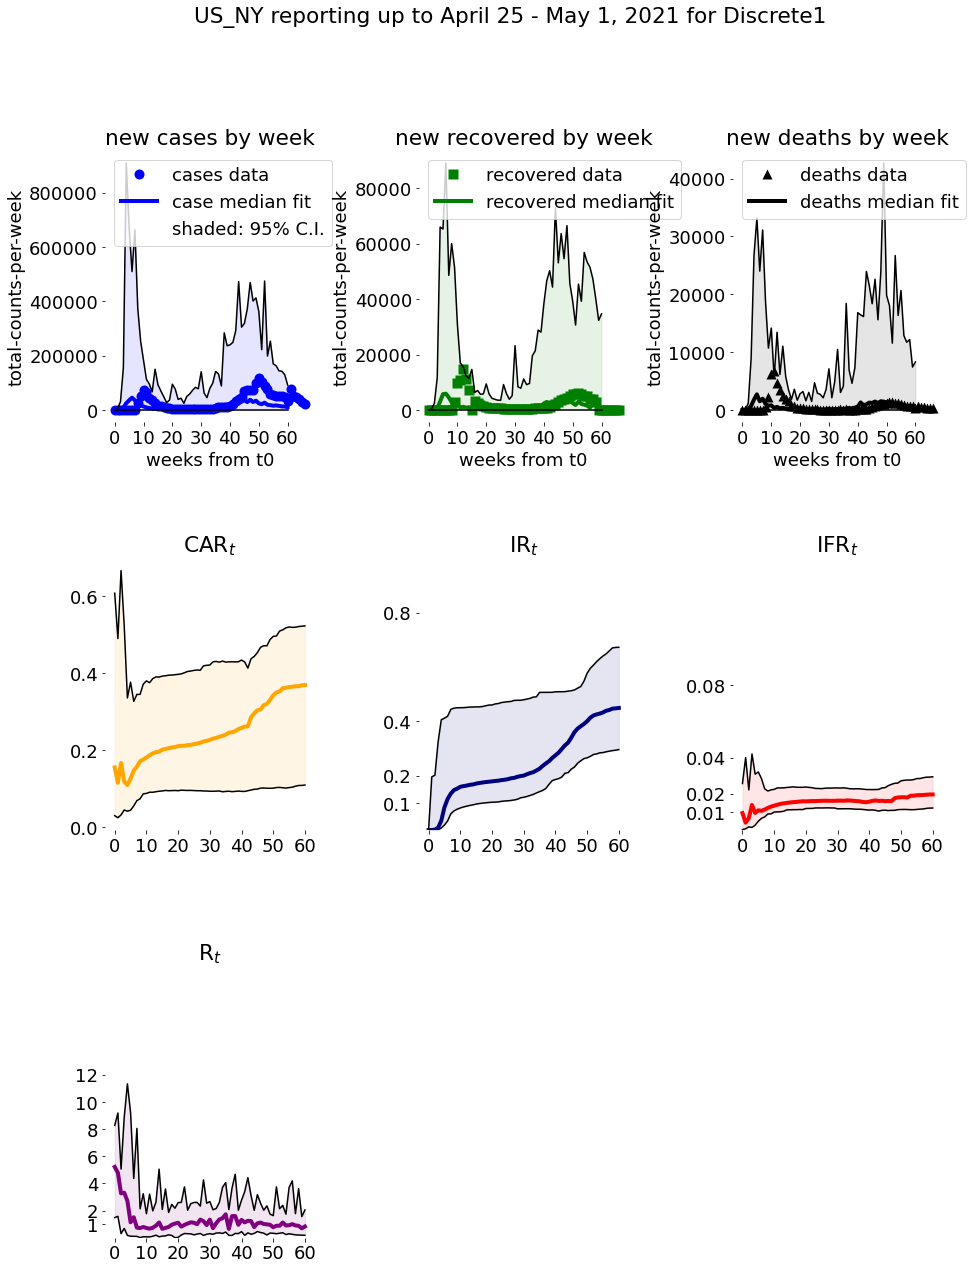

In [47]:
models = []
models.append(model)


df = load_and_format(casepath, roi)
for model_name in models:
    print(model_name, roi)
    samples = ncs.extract_samples(fits_path, models_path, model_name, roi, 1)
    nsamples = shape(samples['sigmau'])[0]
    print(nsamples)
    for i in np.arange(1000,1,-1).astype(str):
        try:
            a = samples['y_proj['+i+',1]']
            break
        except:
            pass
    nobs = int(i)
    c = zeros((nsamples,1))
    r = zeros((nsamples,1))
    d = zeros((nsamples,1))
    CARt = zeros((nsamples,1))
    IRt = zeros((nsamples,1))
    IFRt = zeros((nsamples,1))
    Rt = zeros((nsamples,1))

    for i in range(1,nobs+1):
        c = np.hstack((c,samples['y_proj['+str(i)+',1]'][:,None]))
        r = np.hstack((r,samples['y_proj['+str(i)+',2]'][:,None]))
        d = np.hstack((d,samples['y_proj['+str(i)+',3]'][:,None]))
        Rt = np.hstack((Rt,samples['Rt['+str(i)+']'][:,None]))
        CARt = np.hstack((CARt,samples['car['+str(i)+']'][:,None]))
        IFRt = np.hstack((IFRt,samples['ifr['+str(i)+']'][:,None]))
        IRt = np.hstack((IRt,samples['ir['+str(i)+']'][:,None]))

    c = c[:,1:]
    r = r[:,1:]
    d = d[:,1:]
    CARt = CARt[:,1:]
    IRt = IRt[:,1:]
    IFRt = IFRt[:,1:]
    Rt = Rt[:,1:]

    lw = 4
    f,ax = subplots(3,3,figsize=(15,20))
    ax = ax.flatten()
    a = 0.1
    x = arange(nobs)
    plot_ts_weekly(ax[:3],c,r,d,x, df)

    tick_spacing = 10

    ax[3].set_title(r'CAR$_t$')
    ax[3].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plotXt(ax[3],CARt,x,'orange')

    ax[4].set_title(r'IR$_t$')
    ax[4].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plotXt(ax[4],IRt,x,'navy')
    ax[4].set_ylim((0,1))
    ax[4].set_yticks([0.1,0.2,0.4,0.8])

    ax[5].set_title(r'IFR$_t$')
    ax[5].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plotXt(ax[5],IFRt,x,'red')
    ax[5].set_ylim((0,0.15))
    ax[5].set_yticks([0.01,0.02,0.04,0.08])

    ax[6].set_title(r'R$_t$')
    ax[6].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plotXt(ax[6],Rt,x,'purple')
    ax[6].set_ylim((0,20))
    ax[6].set_yticks([1,2,4,6,8,10,12])

    # delete extra empty subfigures
    f.delaxes(ax[7])
    f.delaxes(ax[8])


    suptitle(roi + ' reporting up to {} for {}'.format(last_week, model_name))
    subplots_adjust(wspace=0.5,hspace=0.5)
    f.savefig('{}timeseries_{}_{}_{}.png'.format(figures_path, model_name, roi, last_week))